# Counting DL and DLT histories: paper figures
### Cedric Chauve, 01/02/2019

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import math

## Introduction

This notebook contains the code used to analyse our experimental results and generate the figure in the paper.

## Reading results

In [2]:
# Parameters

# Number of species trees per size
NB_S_TREES    = 100
S_TREES_INDEX = [i for i in range(0,NB_S_TREES)]
# Evolutionary models
EVOL_MODELS = [('U','DL'),('U','DLT'),('R','DL'),('R','DLT')]
# Species tree sizes
K_MIN = 3
K_MAX = 15 #32
K_LIST = [k for k in range(K_MIN,K_MAX+1)]
# Histories sizes
N_MIN = 1
N_MAX = 50
N_LIST = [n for n in range(N_MIN,N_MAX+1)]
# Paths to results
PREFIX_UNRANKED    = '../../exp/09-01-2019-exp1-redone/results/exp1a'
PREFIX_RANKED      = '../../exp/01-02-2019-exp1-ranking/results/exp1'
PREFIX_ASYMPTOTICS = '../../exp/29-01-2019-exp1-redone-2/systems/exp1a'
# Rankings
R_MAX  = 10
R_LIST = [r for r in range(1,R_MAX+1)]

In [3]:
# Subset of the parameter space for more readable figures
K_LIST_REDUCED = [4,6,8,10,12,14]
N_LIST_REDUCED = [10,20,30,40,50]

In [4]:
# Reading the exact counting results
# Format: RESULTS_ALL[evol_model][s][n][tree_index] is 
# the list of the number of histories of size n for tree tree_index of size s in model evol_model 
# the list is of size 1 if the tree is unranked

RESULTS_aux = {m:{k:{n:{t:[] for t in S_TREES_INDEX} for n in N_LIST}  for k in K_LIST} for m in EVOL_MODELS}
    
def read_counting_file(fileName,k):
    with gzip.open(fileName, 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0]!='#':
                model     = (row[2],row[3])
                treeIndex = int(row[1])
                row5      = row[5].split()
                for n in N_LIST:
                    RESULTS_aux[model][k][n][treeIndex].append(int(row5[n-1]))
    
for k in K_LIST:
    read_counting_file(PREFIX_UNRANKED+'_'+str(k)+'.gz',k)
    read_counting_file(PREFIX_RANKED+'_'+str(k)+'.gz',k)
                            
RESULTS_COUNTING = pd.DataFrame.from_dict({(m,k,n): RESULTS_aux[m][k][n]
                                            for m in RESULTS_aux.keys() 
                                            for k in RESULTS_aux[m].keys()
                                            for n in RESULTS_aux[m][k].keys()},
                                            orient='index')

In [5]:
# Reading the asymptotics results for the model (U,DL)

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    dataAsympt = open(PREFIX_ASYMPTOTICS+'_'+str(k)+'_asy').readlines()
    for row in dataAsympt:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            asymptotics =  float(row1[2])
            RESULTS_aux[k][treeIndex] = asymptotics
RESULTS_ASYMPTOTICS_U_DL = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

In [6]:
# Reading the number of subtrees per species tree

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    subtrees = open(PREFIX_UNRANKED+'_'+str(k)+'_add1').readlines()
    for row in subtrees:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            nbSubtrees    = row1[3].count('(')
            RESULTS_aux[k][treeIndex] = nbSubtrees
RESULTS_SUBTREES = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

## Asymptotics in the unranked DL model

We first look at the simplest model, the unranked DL model, where we can obtain precise asymptotics estimates. We look at the exponential growth factor, the constant, and we look at the correlation between the exponential growth factor and the number of subtrees of the considered species tree, that gives the size of the grammar.

<Figure size 432x288 with 0 Axes>

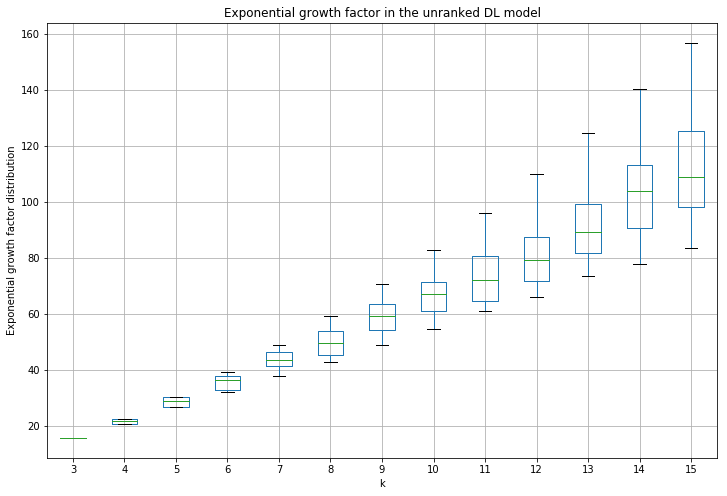

In [7]:
plt.figure()
ax_asympt1 = RESULTS_ASYMPTOTICS_U_DL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Exponential growth factor in the unranked DL model')
ax_asympt1.set_ylabel('Exponential growth factor distribution')
ax_asympt1.set_xlabel('k')
plt.savefig('growth_factor_U_DL.png')
plt.show()

In [8]:
# Computing the constants
CONSTANTS_U_DL_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    for t in S_TREES_INDEX:
        n = N_MAX
        exact    = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
        growth   = RESULTS_ASYMPTOTICS_U_DL.at[k,t]
        asympt   = math.pow(growth,n) / math.pow(n,1.5)
        constant = exact / asympt
        CONSTANTS_U_DL_aux[k][t] = constant
CONSTANTS_U_DL = pd.DataFrame.from_dict({k: CONSTANTS_U_DL_aux[k]
                                        for k in CONSTANTS_U_DL_aux.keys()},
                                        orient='index')

<Figure size 432x288 with 0 Axes>

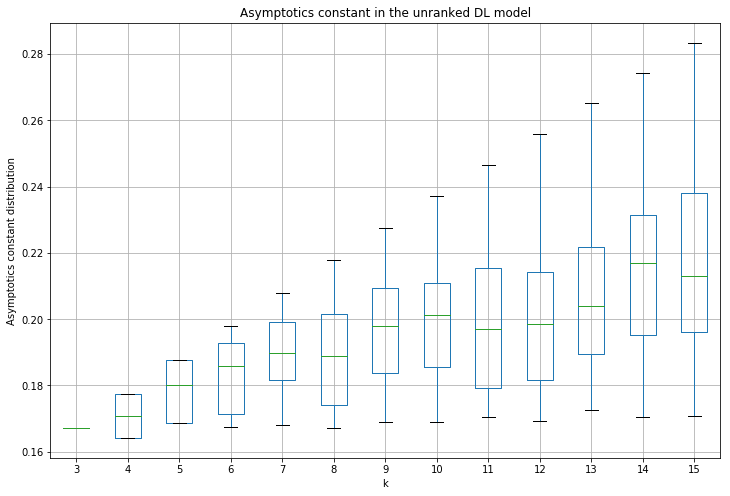

In [9]:
plt.figure()
ax_asympt2 = CONSTANTS_U_DL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Asymptotics constant in the unranked DL model')
ax_asympt2.set_ylabel('Asymptotics constant distribution')
ax_asympt2.set_xlabel('k')
plt.savefig('constants_U_DL.png')
plt.show()

In [10]:
# Creating a dataframe matching exp. growth and number of subtrees
RESULTS_SUBTREES_ASYMPTOTICS =  pd.concat([pd.DataFrame(RESULTS_SUBTREES.stack(),columns=['subtrees']),
                                           pd.DataFrame(RESULTS_ASYMPTOTICS_U_DL.stack(),columns=['exp. growth'])],
                                           axis=1)

<Figure size 432x288 with 0 Axes>

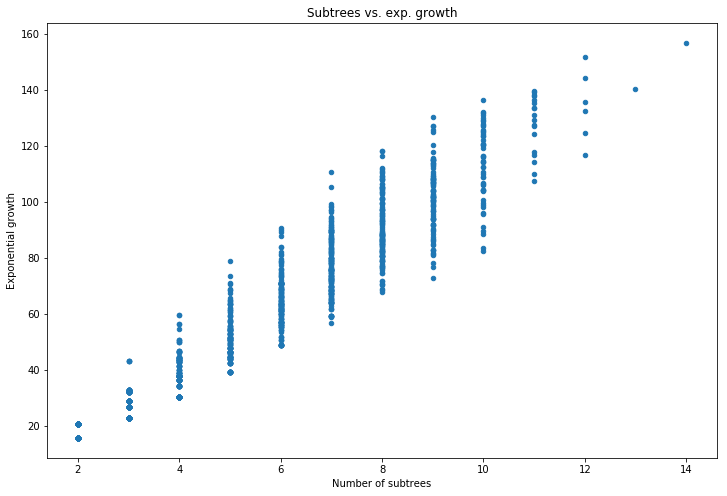

In [11]:
plt.figure()
ax_asympt3 = RESULTS_SUBTREES_ASYMPTOTICS.plot(kind='scatter', x='subtrees', y='exp. growth', figsize=(12,8), title='Subtrees vs. exp. growth')
ax_asympt3.set_xlabel('Number of subtrees')
ax_asympt3.set_ylabel('Exponential growth')
plt.savefig('Nb_subtrees_vs_exp_growth_U_DL.png')
plt.show()

## Spread of the number of histories

For the four models, and for each species tree size, we compute the ratio between the maximum number of histories and the minimum number of histories, and we record the species tree for both. In the ranked case, this is taken over all the pairs (species tree, ranking).

In [12]:
# Aggregating the exact counting results per value of n

RESULTS_aux = {m: {k:{n:[] for n in N_LIST} for k in K_LIST} for m in EVOL_MODELS}
for m in EVOL_MODELS:
    for k in K_LIST:
        for n in N_LIST:
            for t in S_TREES_INDEX:
                nbHistories = RESULTS_COUNTING.at[(m,k,n),t]
                RESULTS_aux[m][k][n] += nbHistories
RESULTS_COUNTING_PER_N = pd.DataFrame.from_dict({(m,k): RESULTS_aux[m][k]
                                            for m in RESULTS_aux.keys() 
                                            for k in RESULTS_aux[m].keys()},
                                            orient='index')

In [13]:
def max_min_ratio(counting):
    return(max(counting)/min(counting))

RESULTS_MAX_MIN_RATIO_PER_N = RESULTS_COUNTING_PER_N.applymap(max_min_ratio)

<Figure size 432x288 with 0 Axes>

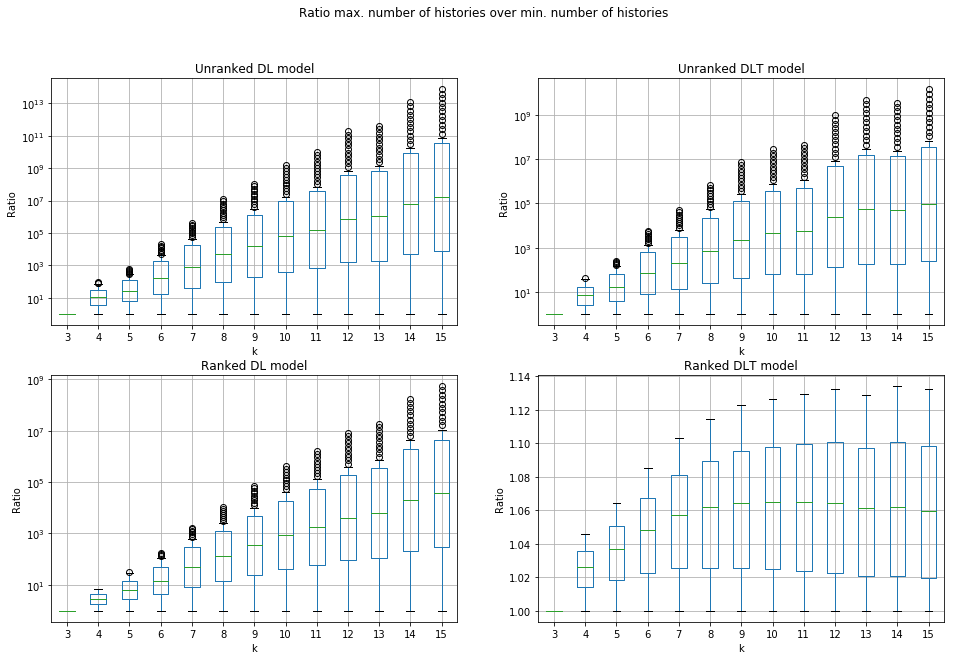

In [14]:
plt.figure()
fig_spread1, ax_spread1 = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
fig_spread1.suptitle('Ratio max. number of histories over min. number of histories')
RESULTS_MAX_MIN_RATIO_PER_N.loc[('U','DL')].transpose().plot(ax=ax_spread1[0,0], kind='box', grid=True,  title='Unranked DL model')
RESULTS_MAX_MIN_RATIO_PER_N.loc[('U','DLT')].transpose().plot(ax=ax_spread1[0,1],  kind='box', grid=True,  title='Unranked DLT model')
RESULTS_MAX_MIN_RATIO_PER_N.loc[('R','DL')].transpose().plot(ax=ax_spread1[1,0], kind='box', grid=True,  title='Ranked DL model')
RESULTS_MAX_MIN_RATIO_PER_N.loc[('R','DLT')].transpose().plot(ax=ax_spread1[1,1], kind='box', grid=True,  title='Ranked DLT model')
for ax in [ax_spread1[0,0],ax_spread1[0,1],ax_spread1[1,0],ax_spread1[1,1]]:
    ax.set_ylabel('Ratio')
    ax.set_xlabel('k')
for ax in [ax_spread1[0,0],ax_spread1[0,1],ax_spread1[1,0]]:
    ax.set_yscale('log')
plt.savefig('ratio_max_min_histories.png')
plt.show()

### TO DO: extreme topologies
We should look into the topologies giving the in and max number of histories per value of *k*.

## Impact of the ranking.

For each species tree we look at the impact of adding a ranking. For DL and DLT, we record the number nb of histories in the unranked model, the min and max with ranking and we compute the three ratios nb/min, nb/max, max/min.

In [15]:
def get_number(c):
    return(c[0])
def get_min(c):
    return(min(c))
def get_max(c):
    return(max(c))
RESULTS_UNRANKED_PER_TREE_DL    = pd.DataFrame(RESULTS_COUNTING.loc[('U','DL')].stack(),columns=['unranked']).applymap(get_number)
RESULTS_UNRANKED_PER_TREE_DLT   = pd.DataFrame(RESULTS_COUNTING.loc[('U','DLT')].stack(),columns=['unranked']).applymap(get_number)
RESULTS_MIN_RANKED_PER_TREE_DL  = pd.DataFrame(RESULTS_COUNTING.loc[('R','DL')].stack(),columns=['min. ranked']).applymap(get_min)
RESULTS_MIN_RANKED_PER_TREE_DLT = pd.DataFrame(RESULTS_COUNTING.loc[('R','DLT')].stack(),columns=['min. ranked']).applymap(get_min)
RESULTS_MAX_RANKED_PER_TREE_DL  = pd.DataFrame(RESULTS_COUNTING.loc[('R','DL')].stack(),columns=['max. ranked']).applymap(get_max)
RESULTS_MAX_RANKED_PER_TREE_DLT = pd.DataFrame(RESULTS_COUNTING.loc[('R','DLT')].stack(),columns=['max. ranked']).applymap(get_max)
RESULTS_PER_TREE_DL  = pd.concat([RESULTS_UNRANKED_PER_TREE_DL,RESULTS_MIN_RANKED_PER_TREE_DL,RESULTS_MAX_RANKED_PER_TREE_DL],axis=1)
RESULTS_PER_TREE_DLT = pd.concat([RESULTS_UNRANKED_PER_TREE_DLT,RESULTS_MIN_RANKED_PER_TREE_DLT,RESULTS_MAX_RANKED_PER_TREE_DLT],axis=1)
RESULTS_PER_TREE_DL['Ratio unranked/min'] = RESULTS_PER_TREE_DL['unranked'] / RESULTS_PER_TREE_DL['min. ranked']
RESULTS_PER_TREE_DL['Ratio unranked/max'] = RESULTS_PER_TREE_DL['unranked'] / RESULTS_PER_TREE_DL['max. ranked']
RESULTS_PER_TREE_DL['Ratio max/min']      = RESULTS_PER_TREE_DL['max. ranked'] / RESULTS_PER_TREE_DL['min. ranked']
RESULTS_PER_TREE_DLT['Ratio unranked/min'] = RESULTS_PER_TREE_DLT['unranked'] / RESULTS_PER_TREE_DLT['min. ranked']
RESULTS_PER_TREE_DLT['Ratio unranked/max'] = RESULTS_PER_TREE_DLT['unranked'] / RESULTS_PER_TREE_DLT['max. ranked']
RESULTS_PER_TREE_DLT['Ratio max/min']      = RESULTS_PER_TREE_DLT['max. ranked'] / RESULTS_PER_TREE_DLT['min. ranked']

<Figure size 432x288 with 0 Axes>

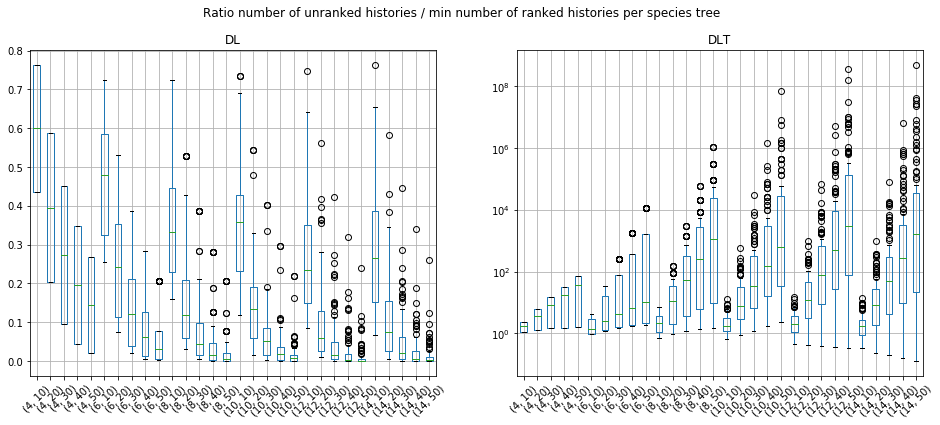

<Figure size 432x288 with 0 Axes>

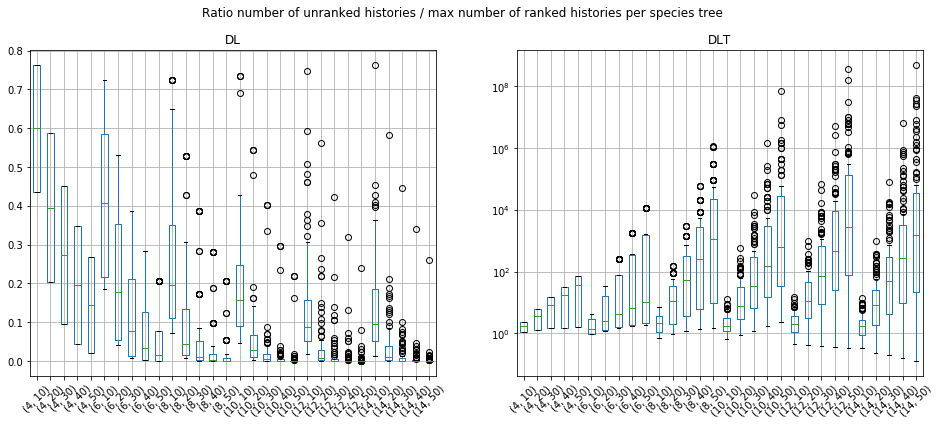

<Figure size 432x288 with 0 Axes>

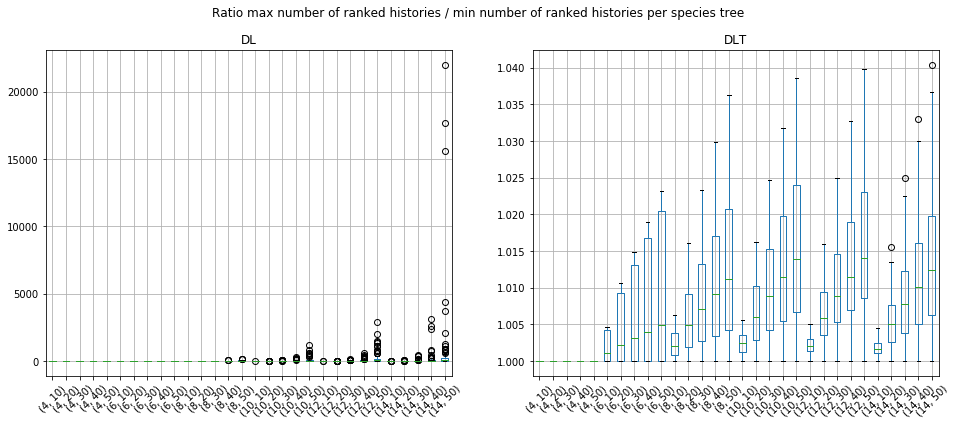

In [16]:
plt.figure()
fig_spread2a, ax_spread2a = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
fig_spread2a.suptitle('Ratio number of unranked histories / min number of ranked histories per species tree')
RESULTS_PER_TREE_DL['Ratio unranked/min'].unstack(level=-1).transpose()[[(k,n) for k in K_LIST_REDUCED for n in N_LIST_REDUCED]].plot(ax=ax_spread2a[0], kind='box', grid=True,  title='DL')
RESULTS_PER_TREE_DLT['Ratio unranked/min'].unstack(level=-1).transpose()[[(k,n) for k in K_LIST_REDUCED for n in N_LIST_REDUCED]].plot(ax=ax_spread2a[1], kind='box', grid=True,  title='DLT')
for ax in ax_spread2a:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
ax_spread2a[1].set_yscale('log')
plt.savefig('ratio_unranked_min_histories_per_tree.png')
plt.show()

plt.figure()
fig_spread2b, ax_spread2b = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
fig_spread2b.suptitle('Ratio number of unranked histories / max number of ranked histories per species tree')
RESULTS_PER_TREE_DL['Ratio unranked/max'].unstack(level=-1).transpose()[[(k,n) for k in K_LIST_REDUCED for n in N_LIST_REDUCED]].plot(ax=ax_spread2b[0], kind='box', grid=True,  title='DL')
RESULTS_PER_TREE_DLT['Ratio unranked/max'].unstack(level=-1).transpose()[[(k,n) for k in K_LIST_REDUCED for n in N_LIST_REDUCED]].plot(ax=ax_spread2b[1], kind='box', grid=True,  title='DLT')
for ax in ax_spread2b:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
ax_spread2b[1].set_yscale('log')
plt.savefig('ratio_unranked_max_histories_per_tree.png')
plt.show()

plt.figure()
fig_spread2c, ax_spread2c = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
fig_spread2c.suptitle('Ratio max number of ranked histories / min number of ranked histories per species tree')
RESULTS_PER_TREE_DL['Ratio max/min'].unstack(level=-1).transpose()[[(k,n) for k in K_LIST_REDUCED for n in N_LIST_REDUCED]].plot(ax=ax_spread2c[0], kind='box', grid=True,  title='DL')
RESULTS_PER_TREE_DLT['Ratio max/min'].unstack(level=-1).transpose()[[(k,n) for k in K_LIST_REDUCED for n in N_LIST_REDUCED]].plot(ax=ax_spread2c[1], kind='box', grid=True,  title='DLT')
for ax in ax_spread2c:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.savefig('ratio_ranked_max_min_histories_per_tree.png')
plt.show()

## Ratio DLT-histories / DL-histories in the unranked model
We compute the ratio between the number of DLT-histories and the number of DL-histories

In [17]:
RESULTS_aux = {k:{n:{t:0 for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            dlth = RESULTS_COUNTING.at[(('U','DLT'),k,n),t][0]
            dlh  = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
            RESULTS_aux[k][n][t] = dlth/dlh
RATIOS_U_DLT_DL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

In [20]:
RESULTS_aux = {k:{n:{(t,r): 0 for r in R_LIST for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            for r in R_LIST:
                dlth = RESULTS_COUNTING.at[(('R','DLT'),k,n),t][r-1]
                dlh  = RESULTS_COUNTING.at[(('R','DL'),k,n),t][r-1]
                RESULTS_aux[k][n][(t,r)] = dlth/dlh
RATIOS_R_DLT_DL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

<Figure size 432x288 with 0 Axes>

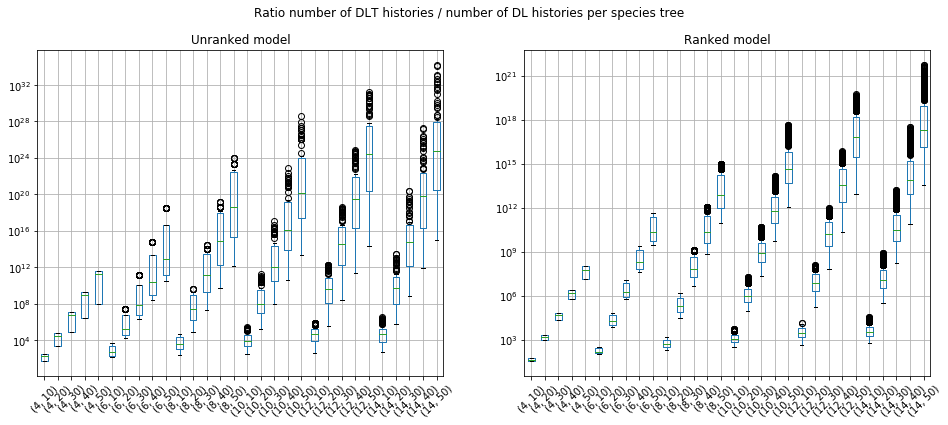

In [19]:
plt.figure()
fig_ratio1, ax_ratio1 = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
fig_ratio1.suptitle('Ratio number of DLT histories / number of DL histories per species tree')
RATIOS_U_DLT_DL.transpose().plot(ax=ax_ratio1[0], kind='box', grid=True, return_type='axes', title='Unranked model')
RATIOS_R_DLT_DL.transpose().plot(ax=ax_ratio1[1], kind='box', grid=True, return_type='axes', title='Ranked model')
for ax in ax_ratio1:
    ax.set_yscale('log')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.savefig('ratio_DLT_DL_per_tree.png')
plt.show()